# Fraud detection using unlabelled data
This chapter focuses on using unsupervised learning techniques to detect fraud. You will segment customers, use K-means clustering and other clustering algorithms to find suspicious occurrences in your data.

## Exploring your data
In the next exercises, you will be looking at bank payment transaction data. The financial transactions are categorized by type of expense, as well as the amount spent. Moreover, you have some client characteristics available such as age group and gender. Some of the transactions are labelled as fraud; you'll treat these labels as given and will use those to validate the results.

When using unsupervised learning techniques for fraud detection, you want to distinguish normal from abnormal (thus potentially fraudulent) behavior. As a fraud analyst to understand what is "normal", you need to have a good understanding of the data and its characteristics. Let's explore the data in this first exercise.

In [8]:
from pandas import read_pickle

df = read_pickle('data/fraud_ch3.pkl')

# Get the dataframe shape
print('Dataframe shape', df.shape)

# Display the first 5 rows
print(df.head())

# Groupby categories and take the mean
print(df.groupby('category').mean())

Dataframe shape (7200, 5)
  age gender           category  amount  fraud
0   3      F  es_transportation   49.71      0
1   4      F          es_health   39.29      0
2   3      F  es_transportation   18.76      0
3   4      M  es_transportation   13.95      0
4   2      M  es_transportation   49.87      0
                           amount     fraud
category                                   
es_barsandrestaurants   43.841793  0.022472
es_contents             55.170000  0.000000
es_fashion              59.780769  0.020619
es_food                 35.216050  0.000000
es_health              126.604704  0.242798
es_home                120.688317  0.208333
es_hotelservices       172.756245  0.548387
es_hyper                46.788180  0.125000
es_leisure             229.757600  1.000000
es_otherservices       149.648960  0.600000
es_sportsandtoys       157.251737  0.657895
es_tech                132.852862  0.179487
es_transportation       27.422014  0.000000
es_travel              231.81865

We can see that the majority of fraud is observed in travel, leisure and sports related transactions.

## Customer segmentation
In this exercise you're going to check whether there are any obvious patterns for the clients in this data, thus whether you need to segment your data into groups, or whether the data is rather homogenous.

You unfortunately don't have a lot client information available; you can't for example distinguish between the wealth levels of different clients. However, there is data on **age ** available, so let's see whether there is any significant difference between behavior of age groups.

In [2]:
# Group by age groups and get the mean
print(df.groupby('age').mean())

# Count the values of the observations in each age group
print('Value counts for each age group')
print(df['age'].value_counts())

        amount     fraud
age                     
0    49.468935  0.050000
1    35.622829  0.026648
2    37.228665  0.028718
3    37.279338  0.023283
4    36.197985  0.035966
5    37.547521  0.023990
6    36.700852  0.022293
U    39.117000  0.000000
Value counts for each age group
2    2333
3    1718
4    1279
5     792
1     713
6     314
0      40
U      11
Name: age, dtype: int64


Based on the results you see, does it make sense to divide your data into age segments before running a fraud detection algorithm?

No, the age groups who are the largest are relatively similar. As you can see the average amount spent as well as fraud occurrence is rather similar across groups. Age group '0' stands out but since there are only 40 cases, it does not make sense to split these out in a separate group and run a separate model on them.

## Using statistics to define normal behavior
In the previous exercises we saw that fraud is more prevalent in certain transaction categories, but that there is no obvious way to segment our data into for example age groups. This time, let's investigate the average amounts spend in normal transactions versus fraud transactions. This gives you an idea of how fraudulent transactions differ structurally from normal transactions.

In [3]:
from matplotlib import pyplot as plt

# Create two dataframes with fraud and non-fraud data
df_fraud = df.loc[df.fraud == 1]
df_non_fraud = df.loc[df.fraud == 0]

# Plot histograms of the amounts in fraud and non-fraud data
plt.hist(df_fraud.amount, alpha=0.5, label='fraud')
plt.hist(df_non_fraud.amount, alpha=0.5, label='nonfraud')
plt.legend()
plt.show()

<Figure size 640x480 with 1 Axes>

As the number fraud observations is much smaller, it is difficult to see the full distribution. Nonetheless, you can see that the fraudulent transactions tend to be on the larger side relative to normal obervations. This is good news, as it helps us later in detecting fraud from non-fraud. In the next chapter you're going to implement a clustering model to distinguish between normal and abnormal transactions, when the fraud labels are no longer available.

## Scaling the data
For ML algorithms using distance based metrics, it is crucial to always scale your data, as features using different scales will distort your results. K-means uses the Euclidian distance to assess distance to cluster centroids, therefore you first need to scale your data before continuing to implement the algorithm. Let's do that first.

In [9]:
from pandas import get_dummies

def prepare_data(df):
    # Make copy
    copy_df = df.copy()

    # Remove under age related data
    copy_df = copy_df[copy_df.age != 'U']

    # Create the Paid_Job column filled with zeros
    copy_df['M'] = 0

    # Binarize gender column
    copy_df.loc[copy_df['gender'] == 'M', 'M'] = 1

    # Replace prefix
    copy_df.category = copy_df.category.str.replace('category_', '')

    # Create dummy variables for the category column
    dummy = get_dummies(copy_df, columns=['category'], drop_first=True, prefix='', prefix_sep='')

    # Grab labels
    labels = dummy['fraud']

    # Drop columns
    final_df = dummy.drop(['gender', 'fraud'], axis=1)

    return labels, final_df

In [13]:
# Import the scaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Prepare Data
labels, df = prepare_data(df)

# Take the float values of df for X
X = df.values.astype(np.float64)

# Define the scaler and apply to the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

Our dataset is now ready to be used in the K-means clustering algorithm in the next exercise.

## K-means clustering
A very commonly used clustering algorithm is K-means clustering. For fraud detection, K-means clustering is straightforward to implement and relatively powerful in predicting suspicious cases. It is a good algorithm to start with when working on fraud detection problems. However, fraud data is oftentimes very large, especially when you are working with transaction data. MiniBatch K-means is an efficient way to implement K-means on a large dataset, which you will use in this exercise.

In [14]:
# Import MiniBatchKmeans
from sklearn.cluster import MiniBatchKMeans

# Define the model
kmeans = MiniBatchKMeans(n_clusters=8, random_state=0)

# Fit the model to the scaled data
kmeans.fit(X_scaled)

MiniBatchKMeans(random_state=0)

You have now fitted your MiniBatch K-means model to the data. In the upcoming exercises you're going to explore whether this model is any good at flagging fraud. But before doing that, you still need to figure our what the right number of clusters to use is. Let's do that in the next exercise.

## Elbow method
In the previous exercise you've implemented MiniBatch K-means with 8 clusters, without actually checking what the right amount of clusters should be. For our first fraud detection approach, it is important to get the number of clusters right, especially when you want to use the outliers of those clusters as fraud predictions. To decide which amount of clusters you're going to use, let's apply the Elbow method and see what the optimal number of clusters should be based on this method.

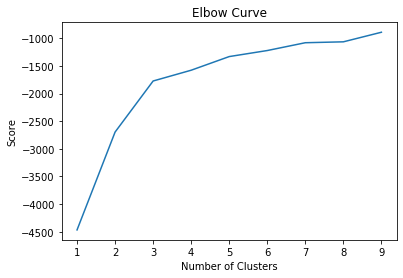

In [16]:
# Define the range of clusters to try
clustno = range(1, 10)

# Run MiniBatch Kmeans over the number of clusters
kmeans = [MiniBatchKMeans(n_clusters=i) for i in clustno]

# Obtain the score for each model
score = [kmeans[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans))]

# Plot the models and their respective score
plt.plot(clustno, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

Now you can see that the optimal number of clusters should probably be at around 3 clusters, as that is where the elbow is in the curve. We'll use this in the next exercise as our baseline model, and see how well this does in detecting fraud